<a href="https://colab.research.google.com/github/DanieleFoscarin/HDA2021/blob/main/Remake_ESC50_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Fine tuning reference https://www.kaggle.com/sgcuber24/fine-tune-mobilenet-v2

Model choice reference https://towardsdatascience.com/how-to-choose-the-best-keras-pre-trained-model-for-image-classification-b850ca4428d4

In [ ]:
# TODO change chromagram with gammatone

# ! pip install git+https://github.com/detly/gammatone.git --quiet
# import gammatone

In [ ]:
# ! pip install brian2hears --quiet
# import brian2 as b2
# import brian2hears as b2h

In [1]:
! pip install icecream --quiet
from icecream import ic

In [2]:
from pathlib import Path
from scipy.io import wavfile
from IPython.display import Audio
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt 
import librosa
from tqdm import tqdm, tqdm_notebook, notebook
import gc
import time 
# import numba
import os
import scipy.fftpack
import cv2


import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.utils import Sequence, SequenceEnqueuer   # try enquerer that uses parallelism
from tensorflow import keras
from tensorflow.keras.layers import BatchNormalization

#import model 
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2

sr = 44100

In [ ]:
! pip install optuna --quiet
import optuna

     |████████████████████████████████| 296kB 9.0MB/s 
     |████████████████████████████████| 1.2MB 34.9MB/s 
     |████████████████████████████████| 81kB 10.0MB/s 
     |████████████████████████████████| 81kB 12.3MB/s 
     |████████████████████████████████| 51kB 7.7MB/s 
     |████████████████████████████████| 112kB 58.6MB/s 
     |████████████████████████████████| 143kB 55.3MB/s 


In [3]:
!pip install livelossplot --quiet
from livelossplot import PlotLossesKeras

# Get Dataset

In [4]:
# Clone the entire repo.
!git clone https://github.com/karolpiczak/ESC-50.git


Cloning into 'ESC-50'...
remote: Enumerating objects: 4154, done.
remote: Counting objects: 100% (18/18), done.
remote: Compressing objects: 100% (18/18), done.
remote: Total 4154 (delta 10), reused 0 (delta 0), pack-reused 4136
Receiving objects: 100% (4154/4154), 878.78 MiB | 26.30 MiB/s, done.
Resolving deltas: 100% (257/257), done.
Checking out files: 100% (2011/2011), done.


In [5]:
ROOT = '/content/ESC-50/audio/'

data_info = pd.read_csv(ROOT+"../meta/esc50.csv")

#make a category dictionary
category_dict = dict(zip(data_info['target'], data_info['category']))
# to_onehot_dict = dict(zip(range(0,50), np.))

#remove unused coumn and add other
# aug_col = np.zeros((len(data_info),1))
# mixup_col = -1 * np.ones((len(data_info),1))
# data_info.drop('esc10', axis=1, inplace=True)
# data_info.drop('src_file', axis=1, inplace=True)
# data_info.drop('take', axis=1, inplace=True)

# data_info['augmentation'] = aug_col
# data_info['mixup'] = mixup_col

# # one hot encoding from category
# data_info = pd.get_dummies(data_info, columns=["category"], prefix='', prefix_sep='') 


data_info

,filename,fold,target,category,esc10,src_file,take
0,1-100032-A-0.wav,1,0,dog,True,100032,A
1,1-100038-A-14.wav,1,14,chirping_birds,False,100038,A
2,1-100210-A-36.wav,1,36,vacuum_cleaner,False,100210,A
3,1-100210-B-36.wav,1,36,vacuum_cleaner,False,100210,B
4,1-101296-A-19.wav,1,19,thunderstorm,False,101296,A
...,...,...,...,...,...,...,...
1995,5-263831-B-6.wav,5,6,hen,False,263831,B
1996,5-263902-A-36.wav,5,36,vacuum_cleaner,False,263902,A
1997,5-51149-A-25.wav,5,25,footsteps,False,51149,A
1998,5-61635-A-8.wav,5,8,sheep,False,61635,A


ic| len(audio_loader): 2000


<class 'pandas.core.series.Series'>
washing_machine


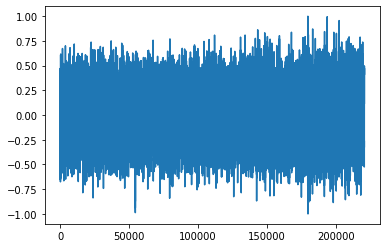

In [6]:
class AudioLoader():
    def __init__(self, df, root, format1=False):
        self.df = df
        self.root = root
        self.format1 = format1

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        _, this_audio = wavfile.read(os.path.join(self.root, self.df['filename'][idx]))
        if self.format1:
            this_audio = this_audio / 32768
        return this_audio

    def get_info(self, idx, list=False):
        if list:
            out = self.df.iloc[idx].to_list()
        else:
            out = self.df.iloc[idx]
        return out


audio_loader = AudioLoader(data_info, ROOT, True)
ic(len(audio_loader))
plt.plot(audio_loader[123])
print(type(audio_loader.get_info(123)))
print(audio_loader.get_info(123)['category'])

# Try first with very basic preprocessing and classification
without kfold or slicing

Save numpy files on disk in and keep using only filenames

Augmentation

In [7]:
# ! mkdir -p mel_storage
# path_mel = "/content/mel_storage/"

# ! mkdir -p mfcc_storage
# path_mfcc = "/content/mfcc_storage/"

# ! mkdir -p chroma_storage
# path_chroma = "/content/chroma_storage/"

# path_list = [path_mel, path_mfcc, path_chroma]

!mkdir -p feature_storage
path_batch = "/content/feature_storage/"

path_drive = '/content/drive/MyDrive/UNI_ICT/HDA/data/' 

# Preprocessing functions

remeber to apply augmentation and mixup only on the training samples, foldwise

## Removing silence

removing silence at the beginning or at the end of the audio clip

In [8]:
def removeSilence(signal, fill_silence=False):
    """
    Remove the leading and trailing zeros in an array,
    Parameters:
        signal: array,
        fill_silence: boolean, if True it repeats the non zero part until the 
            size of the output array is the same as the input array
    Return:
        an array

    """
    
    trimmed = np.trim_zeros(signal)
    if not fill_silence:
        return trimmed
    if fill_silence:
        lt = len(trimmed)
        ls = len(signal)
        # ic(lt,ls)
        if lt < ls:
          trimmed = np.tile(trimmed, int(np.ceil(ls/lt)))
          trimmed = trimmed[:ls]  
        return trimmed

# ic(len(audio_list[0]))
# a = removeSilence(audio_list[0], fill_silence=True)
# librosa.display.waveplot(a, sr=SR)
# ic(len(audio_list[0]))
# ic(len(a))
# # IPython.display.Audio(a, rate=sr)

## compute spectral features

In [ ]:
# OBSOLETE

# def features2(audio, sr, bands=64,):
#     def normalize01(data):
#         return (data - np.min(data)) / (np.max(data) - np.min(data))

#     def standardize(data):
#         return (data - np.mean(data))/np.std(data)

#     diff = 32
#     this_mel = librosa.amplitude_to_db(librosa.feature.melspectrogram(audio.astype('float32'), sr=sr, hop_length=int(sr*0.01), n_mels=64 ))
#     this_mel = standardize(this_mel)

#     this_diff_mel = np.concatenate((np.diff(this_mel, n=1, axis=1), np.zeros((this_mel.shape[0],1))), axis=1)
#     this_diff_mel = standardize(this_diff_mel)
 
#     # this_flat =  librosa.amplitude_to_db(librosa.feature.spectral_flatness(y=audio, hop_length=int(sr*0.01)))
#     # this_flat = standardize(this_flat)

#     # this_rms = librosa.feature.rms(audio, hop_length=int(sr*0.01))
#     # this_rms = standardize(this_rms)

#     this_mfcc = librosa.feature.mfcc(S=this_mel, sr=sr, n_mfcc=64)
#     this_mfcc = standardize(this_mfcc)
#     # mfcc_diff = np.concatenate((np.diff(this_mfcc[:diff,:], n=1, axis=1), np.zeros((diff,1))), axis=1)
#     # this_mfcc = np.concatenate((this_mfcc, mfcc_diff), axis=0)

#     # this_chroma = librosa.feature.chroma_stft(audio.astype('float32'), sr=sr, hop_length=int(sr*0.01), n_chroma=bands)
#     # this_chroma = scipy.fftpack.dct(this_chroma)
#     # this_chroma = standardize(this_chroma)
#     # chroma_diff = np.concatenate((np.diff(this_chroma[:diff,:], n=1, axis=1), np.zeros((diff,1))), axis=1)
#     # this_chroma = np.concatenate((this_chroma, chroma_diff), axis=0)

#     features = [normalize01(this_mel), normalize01(this_diff_mel), normalize01(this_mfcc)]
#     return features


In [11]:
sr*5 / (int(sr*0.01))
# ceil(len(y) / hop) = n_stft
sr*5/128

1722.65625

ic| np.shape(feat): (3, 96, 501)
ic| np.shape(rms): (501, 1), np.shape(flat): (501, 1)


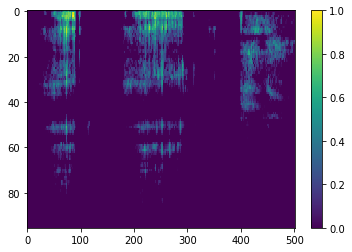

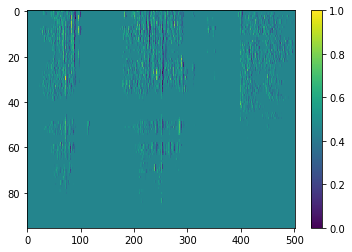

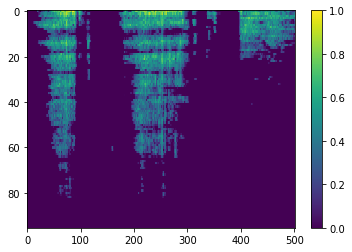

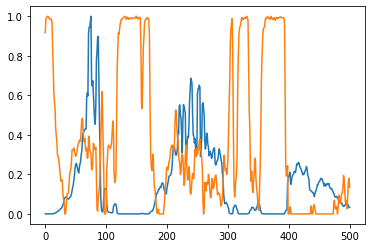

In [20]:
def features3(audio, sr, bands=96,):
    def normalize01(data):
        return (data - np.min(data)) / (np.max(data) - np.min(data))

    def standardize(data):
        return (data - np.mean(data))/np.std(data)

    this_stft = librosa.amplitude_to_db(np.abs(librosa.stft(audio.astype('float32'), hop_length=int(sr*0.01))))
    this_stft = cv2.resize(this_stft, dsize=(501, bands))
    this_stft = standardize(this_stft)

    this_mel = librosa.amplitude_to_db(librosa.feature.melspectrogram(audio.astype('float32'), sr=sr, hop_length=int(sr*0.01), n_mels=bands ))
    this_mel = standardize(this_mel)

    this_diff_mel = np.concatenate((np.diff(this_mel, n=1, axis=1), np.zeros((this_mel.shape[0],1))), axis=1)
    this_diff_mel = standardize(this_diff_mel)
 
    this_flat =  librosa.amplitude_to_db(librosa.feature.spectral_flatness(y=audio, hop_length=int(sr*0.01)))
    this_flat = standardize(this_flat)
    this_flat = np.transpose(this_flat, axes=[1,0])

    this_rms = librosa.feature.rms(audio, hop_length=int(sr*0.01))
    this_rms = standardize(this_rms)
    this_rms = np.transpose(this_rms, axes=[1,0])

    # this_mfcc = librosa.feature.mfcc(S=this_mel, sr=sr, n_mfcc=64)
    # this_mfcc = standardize(this_mfcc)
    # mfcc_diff = np.concatenate((np.diff(this_mfcc[:diff,:], n=1, axis=1), np.zeros((diff,1))), axis=1)
    # this_mfcc = np.concatenate((this_mfcc, mfcc_diff), axis=0)

    # this_chroma = librosa.feature.chroma_stft(audio.astype('float32'), sr=sr, hop_length=int(sr*0.01), n_chroma=bands)
    # this_chroma = scipy.fftpack.dct(this_chroma)
    # this_chroma = standardize(this_chroma)
    # chroma_diff = np.concatenate((np.diff(this_chroma[:diff,:], n=1, axis=1), np.zeros((diff,1))), axis=1)
    # this_chroma = np.concatenate((this_chroma, chroma_diff), axis=0)

    features = [normalize01(this_mel), normalize01(this_diff_mel), normalize01(this_stft)]
    this_rms = normalize01(this_rms)
    this_flat = normalize01(this_flat)

    # features = [this_mel, this_diff_mel, this_mfcc]
    return features, this_rms, this_flat


feat, rms, flat = features3(audio_loader[320], sr)
ic(np.shape(feat))
ic(np.shape(rms), np.shape(flat))


plt.figure()
plt.imshow(feat[0], interpolation='nearest', aspect='auto')
plt.colorbar()

plt.figure()
plt.imshow(feat[1], interpolation='nearest', aspect='auto')
plt.colorbar()

plt.figure()
plt.imshow(feat[2], interpolation='nearest', aspect='auto')
plt.colorbar()

plt.figure()
plt.plot(rms)
plt.plot(flat)

Three in one feature extraction function

In [11]:
#write doc for those functions

def audio_aug2(y, sr=44100, low_ps=-3.5, high_ps=3.5, low_ts=0.8, high_ts=1):
    '''It return a signal with random pitch shift ot time strecth '''

    choice = int(np.random.randint(2))
    if choice == 0:
        step = np.random.uniform(low=low_ps, high=high_ps)
        ya = librosa.effects.pitch_shift(y, sr=sr, n_steps=step)
    elif choice == 1:
        rate = np.random.uniform(low=low_ts, high=high_ts)
        ya = librosa.effects.time_stretch(y, rate)

    ya = ya[:y.shape[0]]
    return ya

def features_preprocessor(audio_loader, path, df, augmentation=0):
    # mel_names = []
    # mfcc_names = []
    # chroma_names = []
    # data_info_aug = data_info.copy()
    # pd_counter = 0


    if augmentation==0:
        for i in notebook.tqdm(range(len(audio_loader))):
            this_audio = audio_loader[i][:sr*5]
            this_audio = removeSilence(this_audio, fill_silence=True)
            these_features, this_rms, this_flat = features3(this_audio, sr)
            pack = np.array([these_features, audio_loader.get_info(i)['fold'], audio_loader.get_info(i)['target'], this_rms, this_flat], dtype= 'object')
            np.save(os.path.join(path, audio_loader.get_info(i)['filename']+'_0'), pack)

    if augmentation > 0:
        for i in notebook.tqdm(range(len(audio_loader))):
            this_audio = audio_loader[i][:sr*5]
            this_audio = removeSilence(this_audio, fill_silence=True)
            for aug in range(augmentation):
                
                if aug == 0:
                    these_features, this_rms, this_flat = features3(this_audio, sr)
                    pack = np.array([these_features, audio_loader.get_info(i)['fold'], audio_loader.get_info(i)['target'], this_rms, this_flat], dtype='object')
                    np.save(os.path.join(path, audio_loader.get_info(i)['filename']+'_0'), pack)
                else:
                    this_audio = audio_aug2(this_audio, sr=sr)
                    these_features, this_rms, this_flat = features3(this_audio, sr)
                    pack = np.array([these_features, audio_loader.get_info(i)['fold'], audio_loader.get_info(i)['target'], this_rms, this_flat], dtype='object')
                    np.save(os.path.join(path, audio_loader.get_info(i)['filename']+'_'+str(aug)), pack)


        

In [21]:
# TODO save the numpy with 3 features together with its info
# so you can load a file having all the info, and no mismatch errors
# then save everything on drive and load from there

# mel_names, data_info_aug = features_preprocessor(audio_list, path_list, data_info, augmentation=0)
ic(ROOT)
audio_loader = AudioLoader(data_info, ROOT, format1=True)
features_preprocessor(audio_loader, path_batch, data_info, augmentation=0)

ic| ROOT: '/content/ESC-50/audio/'


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in true_divide
  


In [ ]:

listdir = os.listdir(path_batch)
asd = np.load(os.path.join(path_batch, listdir[0]), allow_pickle=True)
ic(np.shape(asd[0]))
ic(np.shape(asd[1]))
ic(np.shape(asd[2]))
ic(np.shape(asd[3]))
ic(np.shape(asd[4]))

# lol = features_preprocessor(audio_loader[0], path_batch, data_info)

ic| np.shape(asd[0]): (3, 64, 501)
ic| np.shape(asd[1]): ()
ic| np.shape(asd[2]): ()
ic| np.shape(asd[3]): (501, 1)
ic| np.shape(asd[4]): (501, 1)


(501, 1)

In [ ]:
plist = []
listdir = os.listdir(path_batch)
for file in listdir:
    os.remove(os.path.join(path_batch, file))



test with reading feature packs

In [ ]:
# this_pack = np.load(os.path.join(path_batch, this_fold_names[20]), allow_pickle=True)
# this_feat = np.transpose(this_pack[0], [2,1,0])
# print(category_dict[this_pack[1]])

# ic(np.shape(this_feat))
# plt.figure()
# plt.imshow(this_feat, interpolation='nearest', aspect='auto')

# plt.figure(figsize=(12,6))
# plt.subplot(1,3,1)
# plt.imshow(this_feat[:,:,0], interpolation='nearest', aspect='auto')
# plt.subplot(1,3,2)
# plt.imshow(this_feat[:,:,1], interpolation='nearest', aspect='auto')
# plt.subplot(1,3,3)
# plt.imshow(this_feat[:,:,2], interpolation='nearest', aspect='auto')

make Sequence class

In [26]:
def to_onehot(y, classes=50):
    y_oh = np.zeros((classes, 1))
    y_oh[y] = 1
    return y_oh

def mixup(x1, x2, y1, y2, alpha):
    l = np.random.beta(alpha, alpha)
    x_mix = l*x1 + (1-l)*x2
    y_mix = l*y1 + (1-l)*y2
    return x_mix, y_mix

def mix(a, b, l):
    return l*a + (1-l)*b


class FeatureSequence(Sequence):
    def __init__(self, names, path, batch_size, crop=-1, with_mixup=False):
        self.names = names
        self.batch_size = batch_size
        self.path = path
        self.crop = crop
        self.with_mixup = with_mixup
        self.epoch = 0
        self.alpha = 0.001

    def __len__(self):
        return int(np.floor(len(self.names) / self.batch_size))

    def on_epoch_end(self):
        self.epoch += 1
        if self.alpha < 0.1:
            self.alpha += 0.1/30

    def __getitem__(self, idx):
        batch_names = self.names[idx*self.batch_size:(idx + 1)*self.batch_size]

        batch_feat = []
        batch_rms = []
        batch_flat = []
        batch_target = []
        for name in batch_names:
            this_pack = np.load(os.path.join(self.path, name), allow_pickle=True)
            # NB fix the axes order from the preprocessor
            this_feat = this_pack[0]
            this_feat = np.transpose(this_feat, [2,1,0])
            this_target = to_onehot(this_pack[2])
            this_rms = this_pack[3]
            this_flat = this_pack[4]

            if self.with_mixup and np.random.uniform(0,1)>0.5:
                # load another random pack
                rand_name = np.random.randint(0, len(self.names))
                this_pack2 = np.load(os.path.join(self.path, self.names[rand_name]), allow_pickle=True)
                this_feat2 = this_pack2[0]
                this_feat2 = np.transpose(this_feat2, [2,1,0])
                this_rms2 = this_pack2[3]
                this_flat2 = this_pack2[4]
                this_target2 = to_onehot(this_pack[2])

                # mix the samples
                l = np.random.beta(self.alpha, self.alpha)
                this_feat = mix(this_feat, this_feat2, l)
                this_rms = mix(this_rms, this_rms2, l)
                this_flat = mix(this_flat, this_flat2, l)
                this_target = mix(this_target, this_target2, l)

            if self.crop > 0:
                start = np.random.randint(0, this_feat.shape[0]-self.crop)
                this_feat = this_feat[start:start+self.crop]
                this_rms = this_rms[start:start+self.crop]
                this_flat = this_flat[start:start+self.crop]

            batch_feat.append(this_feat)
            batch_rms.append(this_rms)
            batch_flat.append(this_flat)
            batch_target.append(this_target)

        batch_feat = np.array(batch_feat)
        batch_rms = np.array(batch_rms)
        batch_flat = np.array(batch_flat)
        batch_target = np.array(batch_target)

        batch_input = [batch_feat, batch_rms, batch_flat]

        return batch_input, batch_target


# TODO fix crop decision default
class FeatureSequence(Sequence):
    def __init__(self, names, path, batch_size, crop=-1, with_mixup=False):
        self.names = names
        self.batch_size = batch_size
        self.path = path
        self.crop = crop
        self.with_mixup = with_mixup
        self.epoch = 0
        self.alpha = 0.001

        self.input_shape = (self.crop,96,3)
        self.base_model = MobileNetV2(input_shape=self.input_shape,
                            input_tensor=None,                        
                            include_top=False, 
                            weights='imagenet'
                            )
        self.base_model.trainable = False

        self.img_model = tf.keras.Sequential()
        self.img_model.add(self.base_model)
        self.img_model.add(tf.keras.layers.GlobalAveragePooling2D())
        self.img_model.add(tf.keras.layers.BatchNormalization())

    def __len__(self):
        return int(np.floor(len(self.names) / self.batch_size))

    def on_epoch_end(self):
        self.epoch += 1
        if self.alpha < 0.5:
            self.alpha += 0.5/30

    def __getitem__(self, idx):
        batch_names = self.names[idx*self.batch_size:(idx + 1)*self.batch_size]

        batch_feat = []
        # batch_infered = []
        batch_rms = []
        batch_flat = []
        batch_target = []
        for name in batch_names:
            this_pack = np.load(os.path.join(self.path, name), allow_pickle=True)
            # NB fix the axes order from the preprocessor
            this_feat = this_pack[0]
            this_feat = np.transpose(this_feat, [2,1,0])
            this_target = to_onehot(this_pack[2])
            this_rms = this_pack[3]
            this_flat = this_pack[4]

            if self.with_mixup and np.random.uniform(0,1)>0.5:
                # load another random pack
                rand_name = np.random.randint(0, len(self.names))
                this_pack2 = np.load(os.path.join(self.path, self.names[rand_name]), allow_pickle=True)
                this_feat2 = this_pack2[0]
                this_feat2 = np.transpose(this_feat2, [2,1,0])
                this_rms2 = this_pack2[3]
                this_flat2 = this_pack2[4]
                this_target2 = to_onehot(this_pack[2])

                # mix the samples
                l = np.random.beta(self.alpha, self.alpha)
                this_feat = mix(this_feat, this_feat2, l)
                this_rms = mix(this_rms, this_rms2, l)
                this_flat = mix(this_flat, this_flat2, l)
                this_target = mix(this_target, this_target2, l)

            if self.crop > 0:
                start = np.random.randint(0, this_feat.shape[0]-self.crop)
                this_feat = this_feat[start:start+self.crop]
                this_rms = this_rms[start:start+self.crop]
                this_flat = this_flat[start:start+self.crop]


            batch_feat.append(this_feat)
            # batch_infered.append(this_infered)
            batch_rms.append(this_rms)
            batch_flat.append(this_flat)
            batch_target.append(this_target)

        batch_feat = np.array(batch_feat)

        batch_infered = self.img_model(batch_feat)
        batch_rms = np.array(batch_rms)
        batch_flat = np.array(batch_flat)
        batch_target = np.array(batch_target)

        # batch_input = [batch_infered, batch_rms, batch_flat]
        # try taking out flat
        batch_input = [batch_infered, batch_rms, batch_rms]

        return batch_input, batch_target


# #test
# batch_size = 50
# fold = 2
# this_fold_names = [x for x in feat_names if x[0]==str(fold) and x.endswith('0.npy')]
# feature_sequence = FeatureSequence(this_fold_names, path_batch, batch_size, with_mixup=True)
# b = feature_sequence[0]
# ic(len(b))
# ic(len(b[0]))
# ic(np.shape(b[0][0]))
# ic(np.shape(b[0][1]))
# ic(np.shape(b[0][2]))

# plt.figure()
# plt.plot(b[0][2][0])

# Model classes

Fine tune MobileNetV2

In [ ]:
# careful with shapes is changing data
input_shape = (256,64,3)
base_model = MobileNetV2(input_shape=input_shape,
                        input_tensor=None,                        
                        include_top=False, 
                        weights='imagenet'
                        )
base_model.trainable = False
# base_model.summary()

#define model
model = tf.keras.Sequential()
# model.add(tf.keras.layers.Conv2D(3, kernel_size=(9,9), padding='same', activation='relu', input_shape=input_shape))
model.add(tf.keras.layers.BatchNormalization())
# model.add(tf.keras.layers.Conv2D(3, kernel_size=(3,3), padding='same', activation='relu',))
model.add(tf.keras.layers.BatchNormalization())
model.add(base_model)
model.add(tf.keras.layers.GlobalAveragePooling2D())
model.add(tf.keras.layers.BatchNormalization())

#TODO conv1D here
model.add(tf.keras.layers.Dense(50, activation='relu', kernel_regularizer='l2'))
# model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.BatchNormalization())
# model.add(tf.keras.layers.Dense(100, activation='relu'))
# model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Dense(50, activation='softmax', kernel_regularizer='l2'))
#compile model
model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.001), 
    #   loss = tf.keras.losses.sparse_categorical_crossentropy,
      loss = tf.keras.losses.categorical_crossentropy, 
      metrics=['accuracy'])
# print(model.summary())

In [24]:
crop = 256


def make_MixedNet():
    act = 'relu'

    input_shape = (crop,96,3)

    input_inf = layers.Input(shape=(1280,1))
    input_rms = layers.Input(shape=(crop,1))
    input_flat = layers.Input(shape=(crop,1))
    
    # inf = layers.Dense(10, activation='relu')(input_inf)
    # inf = layers.Conv1D(8, kernel_size=64, padding='same', activation='relu')(input_inf)
    # inf = layers.MaxPool1D()(inf)
    # inf = layers.Conv1D(8, kernel_size=64, padding='same', activation='relu')(inf)
    # inf = layers.MaxPool1D()(inf)

    # rms = layers.Dense(10, activation='relu')(input_rms)
    rms = layers.Conv1D(8, kernel_size=9, padding='same', activation=act, )(input_rms)
    rms = layers.AveragePooling1D()(rms)
    rms = layers.Conv1D(16, kernel_size=9, padding='same', activation=act, )(rms)
    rms = layers.AveragePooling1D()(rms)
    rms = layers.Conv1D(32, kernel_size=9, padding='same', activation=act, )(rms)
    # rms = layers.AveragePooling1D()(rms)
    # rms = layers.Conv1D(64, kernel_size=9, padding='same', activation=act, )(rms)
    # rms = layers.AveragePooling1D()(rms)
    rms = layers.GlobalAveragePooling1D()(rms)
    rms = tf.expand_dims(rms, axis=-1)
    rms = layers.BatchNormalization()(rms)

    out_rms = layers.Flatten()(rms)
    out_rms = layers.Dense(50, activation='softmax', name='out_rms')(out_rms)
    # rms = layers.Flatten()(rms)

    # flat = layers.Dense(10, activation='relu')(input_flat)
    flat = layers.Conv1D(8, kernel_size=9, padding='same', activation=act, )(input_flat)
    flat = layers.AveragePooling1D()(flat)
    flat = layers.Conv1D(16, kernel_size=9, padding='same', activation=act, )(flat)
    flat = layers.AveragePooling1D()(flat)
    flat = layers.Conv1D(32, kernel_size=9, padding='same', activation=act, )(flat)
    # flat = layers.AveragePooling1D()(flat)
    # flat = layers.Conv1D(64, kernel_size=9, padding='same', activation=act, )(flat)
    # flat = layers.AveragePooling1D()(flat)
    flat = layers.GlobalAveragePooling1D()(flat)
    flat = tf.expand_dims(flat, axis=-1)
    flat = layers.BatchNormalization()(flat)

    out_flat = layers.Flatten()(flat)
    out_flat = layers.Dense(50, activation='softmax', name='out_flat')(out_flat)
    # flat = layers.Flatten()(flat)

    z = layers.concatenate([input_inf,rms,flat], axis=1)
    z = layers.Flatten()(z)
    z = layers.Dense(50, activation='softmax', name='out_total')(z)

    # rms = layers.Conv1D(16, 10, padding='same', activation='relu')(input_rms)
    # rms = layers.MaxPool1D()(rms)
    # rms = layers.Conv1D(64, 10, padding='same', activation='relu')(rms)
    # rms = layers.GlobalAveragePooling1D()(rms)

    # flat = layers.Conv1D(16, 10, padding='same', activation='relu')(input_flat)
    # flat = layers.MaxPool1D()(flat)
    # flat = layers.Conv1D(64, 10, padding='same', activation='relu')(flat)
    # flat = layers.GlobalAveragePooling1D()(flat)

    # z = layers.concatenate([img, rms, flat])
    # z = tf.expand_dims(z, axis=-1)
    # z = layers.Conv1D(1, kernel_size=50, activation='softmax')(z)
    # z = layers.GlobalAveragePooling1D()(z)


    model = keras.Model(inputs=[input_inf, input_rms, input_flat], outputs=[out_rms, out_flat, z])
    model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.001), 
      loss = tf.keras.losses.categorical_crossentropy, 
      metrics=['accuracy'])
    return model

mixed_net = make_MixedNet()
mixed_net.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_12 (InputLayer)           [(None, 256, 1)]     0                                            
__________________________________________________________________________________________________
input_13 (InputLayer)           [(None, 256, 1)]     0                                            
__________________________________________________________________________________________________
conv1d_12 (Conv1D)              (None, 256, 8)       80          input_12[0][0]                   
__________________________________________________________________________________________________
conv1d_15 (Conv1D)              (None, 256, 8)       80          input_13[0][0]                   
____________________________________________________________________________________________

training


In [27]:
SOURCE = path_batch

batch_size = 50
epochs = 100

fold = 2
# feat_names  = os.listdir(path_drive)
feat_names  = os.listdir(SOURCE)
ic(len(feat_names))

# not using augmentated samples here
# val_names = [x for x in feat_names if x[0]==str(fold) and x.endswith('0.npy')]
# train_names = [x for x in feat_names if x[0]!=str(fold) and x.endswith('0.npy') or x.endswith('1.npy')]

val_names = [x for x in feat_names if x[0]==str(fold) and x.endswith('0.npy')]
train_names = [x for x in feat_names if x[0]!=str(fold)]


train_dataloader = FeatureSequence(train_names, SOURCE, batch_size, crop=256, with_mixup=False)
val_dataloader = FeatureSequence(val_names, SOURCE, batch_size, crop=256)
# feature_sequence = FeatureSequence(this_fold_names, path_batch, batch_size, with_mixup=True)

ic(len(train_dataloader))
ic(len(val_dataloader))

# TODO need to fine tune this
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=3, min_lr=0.0001)

ic| len(feat_names): 2000


ic| len(train_dataloader): 32
ic| len(val_dataloader): 8


ic| len(b): 2
ic| len(b[0]): 3
ic| np.shape(b[0][0]): TensorShape([50, 1280])
ic| np.shape(b[0][1]): (50, 256, 1)
ic| np.shape(b[0][2]): (50, 256, 1)


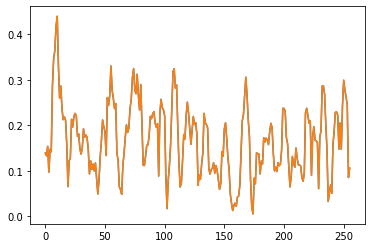

In [28]:
# ic(train_dataloader[0][0].shape)
# ic(val_dataloader[0][0].shape)
b = train_dataloader[30]
ic(len(b))
ic(len(b[0]))
ic(np.shape(b[0][0]))
ic(np.shape(b[0][1]))
ic(np.shape(b[0][2]))

plt.figure()
plt.plot(b[0][1][0])
plt.plot(b[0][2][0])

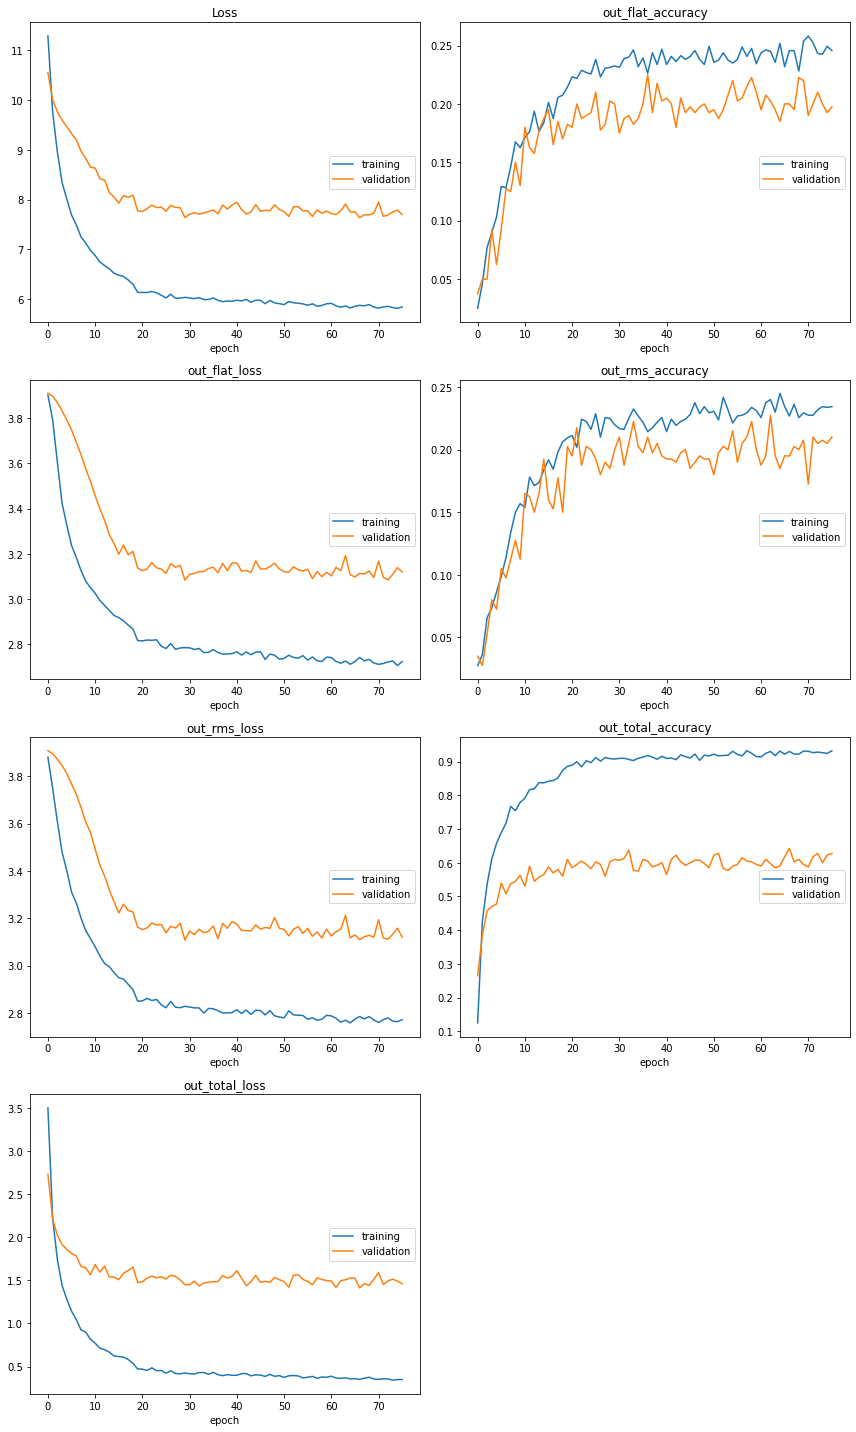

Loss
	training         	 (min:    5.818, max:   11.283, cur:    5.844)
	validation       	 (min:    7.635, max:   10.549, cur:    7.701)
out_flat_accuracy
	training         	 (min:    0.025, max:    0.258, cur:    0.246)
	validation       	 (min:    0.038, max:    0.225, cur:    0.198)
out_flat_loss
	training         	 (min:    2.706, max:    3.902, cur:    2.724)
	validation       	 (min:    3.084, max:    3.910, cur:    3.120)
out_rms_accuracy
	training         	 (min:    0.027, max:    0.245, cur:    0.234)
	validation       	 (min:    0.027, max:    0.228, cur:    0.210)
out_rms_loss
	training         	 (min:    2.758, max:    3.880, cur:    2.771)
	validation       	 (min:    3.108, max:    3.908, cur:    3.120)
out_total_accuracy
	training         	 (min:    0.125, max:    0.933, cur:    0.932)
	validation       	 (min:    0.265, max:    0.642, cur:    0.627)
out_total_loss
	training         	 (min:    0.342, max:    3.501, cur:    0.349)
	validation       	 (min:    1.412, max: 

In [ ]:
#fit the model
history = mixed_net.fit(train_dataloader, 
                    epochs=epochs,
                    callbacks=[PlotLossesKeras(), 
                               reduce_lr],
                    validation_data = val_dataloader,
                    )

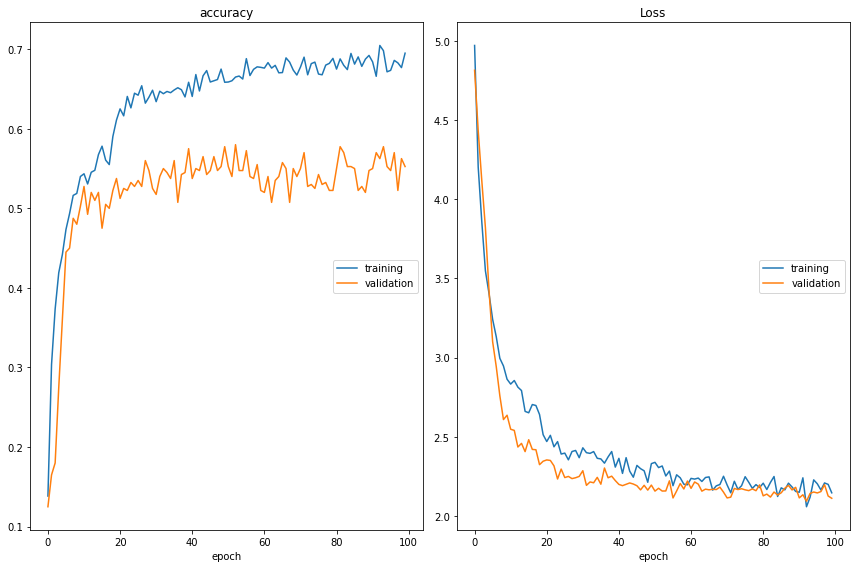

accuracy
	training         	 (min:    0.138, max:    0.705, cur:    0.695)
	validation       	 (min:    0.125, max:    0.580, cur:    0.553)
Loss
	training         	 (min:    2.059, max:    4.971, cur:    2.146)
	validation       	 (min:    2.093, max:    4.815, cur:    2.112)


In [ ]:
#fit the model
history = model.fit(train_dataloader, 
                    # steps_per_epoch=int(len(train_dataloader)//batch_size),
                    epochs=epochs,
                    callbacks=[PlotLossesKeras(), 
                               reduce_lr],
                    validation_data = val_dataloader,
                    # validation_steps=int(len(val_dataloader)//batch_size),
                    )

In [ ]:
#get results
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

#plot results
#accuracy
plt.figure(figsize=(8, 8))
plt.rcParams['figure.figsize'] = [16, 9]
plt.rcParams['font.size'] = 14
plt.rcParams['axes.grid'] = True
plt.rcParams['figure.facecolor'] = 'white'
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.title(f'MobileNetV2 \nTraining and Validation Accuracy. \nTrain Accuracy: {str(round(acc[-1],3))}\nValidation Accuracy: {str(round(val_acc[-1],3))}')

#loss
plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.title(f'Training and Validation Loss. \nTrain Loss: {str(round(loss[-1],3))}\nValidation Loss: {str(round(val_loss[-1],3))}')
plt.xlabel('epoch')
plt.tight_layout(pad=3.0)
plt.show()